In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from typing import Callable
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm


In [2]:
# input shape [batch_size, channel, width, hieght]
class SelfAttentionLayer(nn.Module):
    def __init__(self, in_planes, out_planes, head, similarity_fun: Callable[[torch.tensor], torch.tensor]) -> None:
        super().__init__()
        self.qurey = nn.Conv2d(in_planes, out_planes, kernel_size=1)
        self.key = nn.Conv2d(in_planes, out_planes, kernel_size=1)
        self.value = nn.Conv2d(in_planes, out_planes, kernel_size=1)
        self.similarity_fun = similarity_fun
        self.output = nn.Conv2d(out_planes, in_planes, kernel_size=1)
        self.gamma = nn.Parameter(torch.tensor([0.]))
        self.head = head
        self.out_dim = out_planes // self.head
    
    def forward(self, x):
        shape = x.shape
        batch_size, channels, width, height = shape
        # print("x", x.shape)
        q, k, v = self.qurey(x), self.key(x), self.value(x)        
        #For single head
        # q = q.view(*q.shape[:2], -1)
        # k = k.view(*k.shape[:2], -1)
        # v = v.view(*v.shape[:2], -1)

        #For multi head
        q = q.view(batch_size * self.head, self.out_dim, width * height)
        k = k.view(batch_size * self.head, self.out_dim, width * height)
        v = v.view(batch_size * self.head, self.out_dim, width * height)

        
        a = F.softmax(self.similarity_fun(q, k), dim=-1)

        # print('a', a.shape)
        # print('v', v.shape)
        channels = v.shape[1]
        #For single head
        # o = self.output(torch.bmm(a, v).view(batch_size, channels, width, height))
        #For multi head
        o = self.output(torch.bmm(a, v).view(batch_size, self.out_dim * self.head, width, height))
        # print('val',  o.shape)

        return self.gamma * o + x 


In [3]:
def similarity_fun(Q: torch.tensor, K: torch.tensor):
    # print("Q", Q.shape)
    # print("K.T", K.transpose(1, 2).shape)
    return torch.bmm(Q, K.transpose(1, 2))/torch.sqrt(torch.tensor(K.shape[-1]))

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    

In [5]:
class ModifiedResNetWithAttentionT(nn.Module):
    def __init__(self):
        super(ModifiedResNetWithAttentionT, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = ResidualBlock(16, 32, stride=2)
        # Integrate SelfAttentionLayer after the first Residual Block
        self.att1 = SelfAttentionLayer(32, 64, 4, similarity_fun)  # Adjust parameters as necessary
        self.layer2 = ResidualBlock(32, 64, stride=2)
        # Another SelfAttentionLayer could be added here if desired
        self.att2 = SelfAttentionLayer(64, 128, 4, similarity_fun)  # Adjust parameters as necessary
        self.layer3 = ResidualBlock(64, 128, stride=2)
        self.gpa = nn.AdaptiveAvgPool2d((1, 1))
        self.finalFC = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.att1(x)  # Apply SelfAttention after the first Residual Block
        x = self.layer2(x)
        x = self.att2(x)  # Apply SelfAttention after the second Residual Block
        x = self.layer3(x)
        x = self.gpa(x)
        x = x.view(x.size(0), -1)
        x = self.finalFC(x)
        return x

In [6]:
class ModifiedResNetWithAttention(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ModifiedResNetWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(dropout_rate)
        self.layer1 = ResidualBlock(16, 32, stride=2)
        self.att1 = SelfAttentionLayer(32, 64, 4, similarity_fun)
        self.layer2 = ResidualBlock(32, 64, stride=2)
        self.att2 = SelfAttentionLayer(64, 128, 4, similarity_fun)
        self.layer3 = ResidualBlock(64, 128, stride=2)
        self.gpa = nn.AdaptiveAvgPool2d((1, 1))
        self.finalFC = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.att1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.att2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.gpa(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.finalFC(x)
        return x


In [7]:
class ModifiedResNetWithAttentionD(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ModifiedResNetWithAttentionD, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(dropout_rate)
        self.layer1 = ResidualBlock(16, 32, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.att1 = SelfAttentionLayer(32, 64, 4, similarity_fun)
        self.layer2 = ResidualBlock(32, 64, stride=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.att2 = SelfAttentionLayer(64, 128, 4, similarity_fun)
        self.layer3 = ResidualBlock(64, 128, stride=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.gpa = nn.AdaptiveAvgPool2d((1, 1))
        
        # Adding an additional FC layer
        self.fc1 = nn.Linear(128, 512)  # First additional FC layer
        self.fc2 = nn.Linear(512, 128)  # Second additional FC layer
        self.finalFC = nn.Linear(128, 10)  # Final FC layer for classification

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.layer1(x)
        x = F.relu(self.bn2(x))
        x = self.att1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = F.relu(self.bn3(x))
        x = self.att2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = F.relu(self.bn4(x))
        x = self.gpa(x)
        x = x.view(x.size(0), -1)
        
        # Passing through the additional FC layers with ReLU and dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.finalFC(x)
        return x

In [8]:
class CNN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.convSelf1 = SelfAttentionLayer(16, 32, 4, similarity_fun)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.gpa = nn.AdaptiveAvgPool2d((1, 1))
        self.finalFC = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.convSelf1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.gpa(x)
        x = x.view(-1, 64)
        return self.finalFC(x)

In [53]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
    # New augmentations
    # transforms.RandomRotation(degrees=15),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    # transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
])


# For validation, we usually keep it simple
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Download and load the training dataset
trainset = datasets.CIFAR10(root='./', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

# Download and load the test dataset
testset = datasets.CIFAR10(root='./', train=False,
                                       download=True, transform=transform_val)
testloader = DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


In [62]:
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# model = CNNAttentionModel().to(device)
# model = CNN().to(device)
# model = ModifiedResNetWithAttentionT().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

cuda


In [63]:
import os

def save_checkpoint(state, filename="model_checkpoint.tar"):
    os.makedirs(os.path.dirname(filename), exist_ok=True)  # Ensure directory exists
    torch.save(state, filename)

def load_checkpoint(checkpoint_path, model, optimizer, scheduler=None):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler is not None and 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    return checkpoint.get('epoch', -1), checkpoint.get('best_accuracy', 0.0)

def train_and_validate(model, train_loader, test_loader, optimizer, criterion, device, scheduler=None, num_epochs=5, checkpoint_path=None, filename="checkpoints/model_checkpoint.tar"):
    start_epoch = 0
    best_accuracy = 0.0

    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        start_epoch, best_accuracy = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
        print(f"Loaded checkpoint '{checkpoint_path}' (epoch {start_epoch}), best accuracy: {best_accuracy}%")
        start_epoch += 1  # Continue from next epoch

    for epoch in range(start_epoch, start_epoch + num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{start_epoch + num_epochs}', leave=False):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs + start_epoch}], Loss: {running_loss/len(train_loader):.4f}')
        
        # Update the learning rate scheduler after each epoch
        if scheduler is not None:
            scheduler.step()

        # Validation loop
        model.eval()
        total = 0
        correct = 0
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc='Validating', leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        current_accuracy = 100 * correct / total
        print(f'Validation Accuracy: {current_accuracy:.2f}%')
        
        # Save checkpoint if current accuracy is the best
        if current_accuracy > best_accuracy:
            print("Saving new best model")
            best_accuracy = current_accuracy
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_accuracy': best_accuracy
            }
            if scheduler is not None:
                checkpoint['scheduler_state_dict'] = scheduler.state_dict()
            save_checkpoint(checkpoint, filename=filename)


In [64]:
filepath = "checkpoints\cnn\cnn_MAT__lr_0_001_op_adam_dataA.tar"
# train_and_validate(model, trainloader, testloader, optimizer, criterion, device, scheduler, num_epochs=1, filename=filepath)

In [65]:

train_and_validate(model, trainloader, testloader, optimizer, criterion, device, scheduler, num_epochs=1, checkpoint_path=filepath, filename=filepath)

Loaded checkpoint 'checkpoints\cnn\cnn_MAT__lr_0_001_op_adam_dataA.tar' (epoch 48), best accuracy: 86.38%


Epoch [50/50], Loss: 0.3927


Validation Accuracy: 85.12%


In [14]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_predictions(model, device, dataloader, classes, num_images=5):
    model.eval()  # Ensure the model is in evaluation mode
    
    # Detect if we have a GPU available
    
    model.to(device)  # Ensure the model is on the correct device

    # Fetch a batch of images
    images, labels = next(iter(dataloader))
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)  # Transfer to the same device

    # Get predictions
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Move images back to CPU for visualization
    images = images.to('cpu')
    labels = labels.to('cpu')
    predicted = predicted.to('cpu')

    # Display images
    imshow(torchvision.utils.make_grid(images))
    
    # Print actual and predicted labels
    print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(num_images)))
    print('Predicted: ', ' '.join(f'{classes[predicted[j]]}' for j in range(num_images)))


# Define the CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


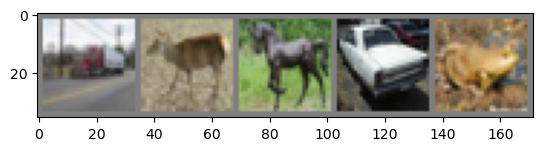

GroundTruth:  truck deer horse car frog
Predicted:  truck deer horse car frog


In [70]:
testloaderPre = DataLoader(testset, batch_size=128,
                                         shuffle=True, num_workers=2)
modelPre =  ModifiedResNetWithAttentionT().to(device)
load_checkpoint("checkpoints\cnn\cnn_MAT__lr_0_001_op_adam_dataA.tar", modelPre, optimizer)
show_predictions(modelPre, device, testloaderPre, classes, num_images=5)

# Vision Transformer

In [29]:
class SelfAttentionLayerTransformer(nn.Module):
    def __init__(self, in_dim, out_dim, heads):
        super().__init__()
        self.query = nn.Linear(in_dim, out_dim)
        self.key = nn.Linear(in_dim, out_dim)
        self.value = nn.Linear(in_dim, out_dim)
        self.heads = heads
        self.out_dim_per_head = out_dim // heads
        self.output = nn.Linear(out_dim, in_dim)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        q = self.query(x).view(batch_size, seq_len, self.heads, self.out_dim_per_head).transpose(1, 2)
        k = self.key(x).view(batch_size, seq_len, self.heads, self.out_dim_per_head).transpose(1, 2)
        v = self.value(x).view(batch_size, seq_len, self.heads, self.out_dim_per_head).transpose(1, 2)
        
        # Calculate the attention scores
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.out_dim_per_head, dtype=torch.float32))
        attention = torch.softmax(attention_scores, dim=-1)
        
        # Apply attention to the values
        out = torch.matmul(attention, v)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        out = self.output(out)
        
        return self.gamma * out + x


In [30]:
# Assuming input shape (batch_size, n_patches, C * patch_size * patch_size)
class AddPositionEmbedding(nn.Module):
    def __init__(self, num_patches, emb_dim) -> None:
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))  # +1 for class token

    def forward(self, x):
        return x + self.pos_embedding


In [31]:
class MlpLayer(nn.Module):
    def __init__(self, input_dim, mlp_dim, dropout=0.5) -> None:
        super().__init__()
        self.layer1 = nn.Linear(input_dim, mlp_dim)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.layer2 = nn.Linear(mlp_dim, input_dim)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.gelu(self.layer1(x))
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.dropout2(x)
        return x

In [32]:
class Encoder(nn.Module):
    def __init__(self, input_dim, patch_size, att_dim, head, mlp_dim, num_patches, dropout=0.5) -> None:
        super().__init__()
        self.ln1 = nn.LayerNorm(input_dim)
        # Adjust the SelfAttentionLayer initialization if needed
        self.att = SelfAttentionLayerTransformer(input_dim, att_dim, head)
        self.ln2 = nn.LayerNorm(att_dim)
        self.mlp = MlpLayer(input_dim, mlp_dim, dropout)

    def forward(self, x):
        # Apply the first LayerNorm
        x = self.ln1(x)
        # Save the input for the skip connection
        x_skip = x
        # Apply the self-attention
        x = self.att(x)
        # Add the skip connection (residual)
        x = x + x_skip

        # Apply the second LayerNorm
        x = self.ln2(x)
        # Save the input for the second skip connection
        x_skip = x
        # Apply the MLP layer
        x = self.mlp(x)
        # Add the second skip connection (residual)
        x = x + x_skip
        
        return x


In [33]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, num_channels, num_classes, emb_dim, num_heads, mlp_dim, num_layers, dropout_rate=0.5):
        super().__init__()
        num_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.emb_dim = emb_dim
        self.flatten_dim = patch_size * patch_size * num_channels
        self.linear_proj = nn.Linear(self.flatten_dim, emb_dim)
        self.class_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = AddPositionEmbedding(num_patches, emb_dim)

        self.layers = nn.ModuleList([
            Encoder(input_dim=emb_dim, patch_size=patch_size, att_dim=emb_dim, head=num_heads, mlp_dim=mlp_dim, num_patches=num_patches, dropout=dropout_rate)
            for _ in range(num_layers)
        ])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, num_classes)
        )

    def forward(self, x):
        # Unfold patches
        x = x.unfold(2, self.patch_size, self.patch_size) \
            .unfold(3, self.patch_size, self.patch_size)
        # Reshape: [Batch, Channels, Patch_height, Patch_width, Num_patches_height, Num_patches_width]
        x = x.permute(0, 4, 5, 1, 2, 3)
        # Flatten patches
        x = x.contiguous().view(x.size(0), -1, self.flatten_dim) # -1 here automatically calculates the correct number of patches
        x = self.linear_proj(x)

        # Add class token and position embeddings
        class_tokens = self.class_token.expand(x.size(0), -1, -1)
        x = torch.cat((class_tokens, x), dim=1)
        x = self.pos_embedding(x)

        # Process through the layers
        for layer in self.layers:
            x = layer(x)

        # Classifier token
        x = x[:, 0]
        x = self.mlp_head(x)
        return x



In [34]:

from torchvision import transforms

# Enhanced data transformations with Color Jitter and Random Erasing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)  # Random erasing
])

# For validation, we usually keep it simple
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = datasets.CIFAR10(root='./', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./', train=False, download=True, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [43]:
import torch.optim.lr_scheduler as lr_scheduler

model = VisionTransformer(
    img_size=32,  
    patch_size=4, 
    num_channels=3,
    num_classes=10,
    emb_dim=256,  
    num_heads=8,  
    mlp_dim=512, 
    num_layers=1,
    dropout_rate=0.1 
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Adjust the optimizer and learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)


# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


criterion = nn.CrossEntropyLoss()

print(device)

cuda


In [44]:
filepath = "checkpoints/transformer/vit_layer_1_lr_0_001_op_adam.tar"
train_and_validate(model, train_loader, test_loader, optimizer, criterion, device, scheduler, num_epochs=1, checkpoint_path=filepath, filename=filepath)

Loaded checkpoint 'checkpoints/transformer/vit_layer_1_lr_0_001_op_adam.tar' (epoch 45), best accuracy: 49.0%


Epoch [47/47], Loss: 1.6009


Validation Accuracy: 50.22%
Saving new best model


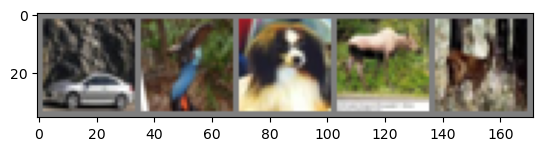

GroundTruth:  car bird dog deer deer
Predicted:  car bird cat cat horse


In [50]:
testloaderPre = DataLoader(testset, batch_size=64,
                                         shuffle=True, num_workers=2)
modelPre =  model = VisionTransformer(
    img_size=32,  
    patch_size=4, 
    num_channels=3,
    num_classes=10,
    emb_dim=256,  
    num_heads=8,  
    mlp_dim=512, 
    num_layers=1,
    dropout_rate=0.1 
).to(device)
load_checkpoint("checkpoints/transformer/vit_layer_1_lr_0_001_op_adam.tar", modelPre, optimizer)
show_predictions(modelPre, device, testloaderPre, classes, num_images=5)